# Investigating Errors

In [1]:
import os
import time

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.svm as skl_svm
import sklearn.cross_validation as skl_cv
from sklearn.grid_search import GridSearchCV

## Loading data

In [2]:
digit_data = pd.read_csv('Data/train.csv')

X = digit_data.ix[:,1:digit_data.shape[1]]
y = digit_data['label']

X_subset = X.ix[0:10000,:]
y_subset = y.ix[0:10000]

## Fitting SVC to subset of data with CV predict

In [3]:
svc_poly_clf = skl_svm.SVC(
    C=2.8e-5, 
    degree=2, 
    gamma='auto', 
    kernel='poly', 
    tol=0.001
)

y_pred_cv = skl_cv.cross_val_predict(svc_poly_clf, X_subset, y_subset, cv = 10)
y_pred_cv = pd.Series(y_pred_cv, index = y_subset.index)

## Getting misclassified data

In [4]:
incorrect_indexes = y_pred_cv != y_subset

y_pred_cv_incorrect = y_pred_cv.ix[incorrect_indexes]
y_subset_incorrect = y_subset.ix[incorrect_indexes]

y_incorrect_df = pd.DataFrame({
        'Actual' : y_subset_incorrect.values,
        'Predicted' : y_pred_cv_incorrect.values
                              })
y_incorrect_df.head(2)

,Actual,Predicted
0,5,6
1,9,3


## Visualizing misclassified data with a heatmap

I first cross-tabulate to get the count of each misclassification and then plot this in a heatmap:

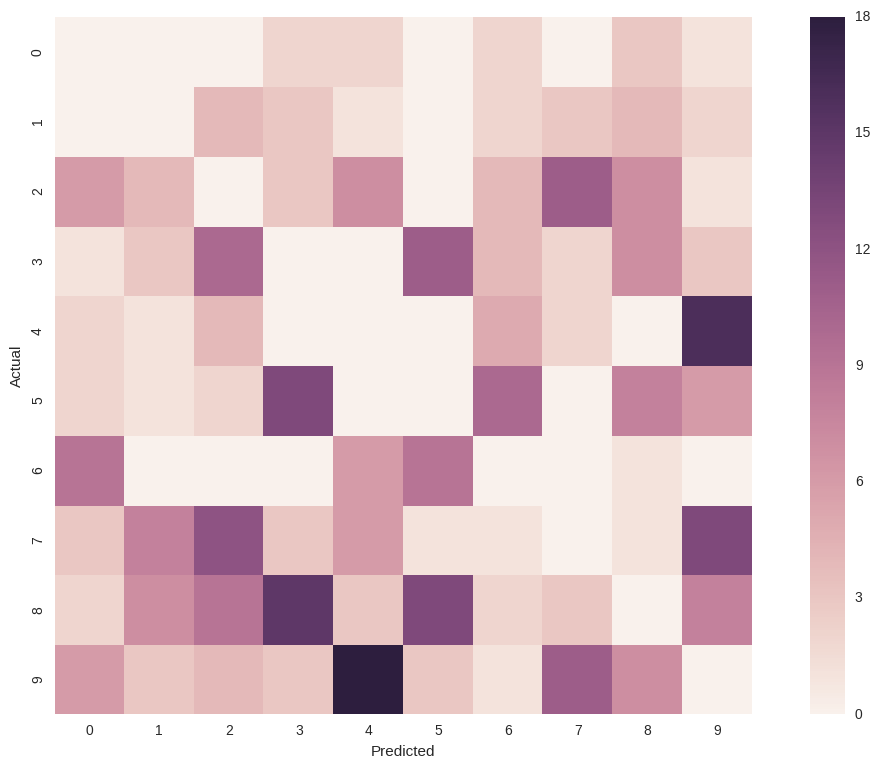

In [5]:
plt.rcParams['figure.figsize'] = 15,9

misclassified_crosstab = pd.crosstab(y_incorrect_df['Actual'], y_incorrect_df['Predicted'])
sns.heatmap(misclassified_crosstab, square=True);

Let's write the misclassified data to disk:

In [6]:
misclassified_crosstab.to_csv('Data/misclassified_crosstab.csv')

#### Looking at the absolute values of misclassifications from the cross-tabulation table

In [7]:
sorted_misclassified_crosstab_unstack = misclassified_crosstab.unstack().sort_values(ascending=False)
sorted_misclassified_crosstab_unstack.head(10)

Predicted  Actual
4          9         18
9          4         16
3          8         15
9          7         13
3          5         13
5          8         13
2          7         12
7          9         11
5          3         11
7          2         11
dtype: int64

The top two misclassifications were 9 <--> 4. 
The third most common was 8 --> 3
The fourth most common was 7 --> 9

#### Looking at which numbers were least commonly misclassified

In [8]:
total_actual_misclassified = sorted_misclassified_crosstab_unstack.reset_index().groupby(['Actual'])[0].sum()
total_actual_misclassified

Actual
0    10
1    19
2    43
3    41
4    30
5    42
6    25
7    48
8    62
9    56
Name: 0, dtype: int64

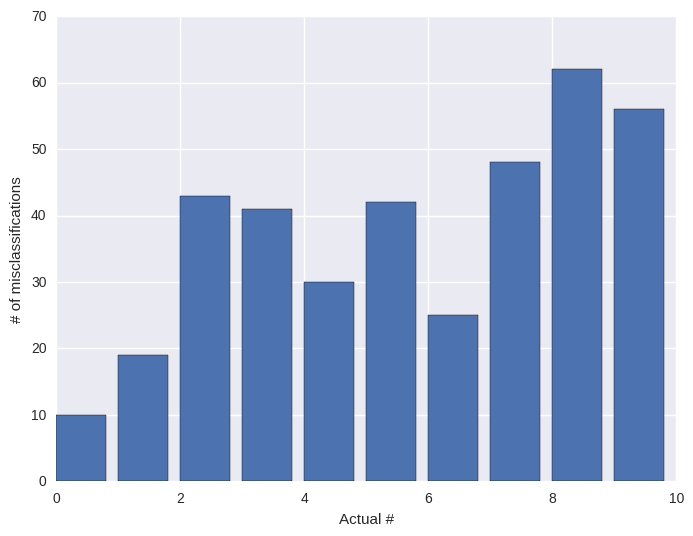

In [9]:
plt.rcParams['figure.figsize'] = 8,6
plt.bar(total_actual_misclassified.index, total_actual_misclassified)
ax = plt.gca()
ax.set_xlabel('Actual #')
ax.set_ylabel('# of misclassifications')

So 0 and 1 were misclassified very rarely. 4 and 6 were classified correctly fairly well. 

8 and 9 were misclassified quite a bit.

## Focusing on number 8

Let's look at the actual number 8. 

In [10]:
sorted_misclassified_crosstab_unstack.ix[:,8]

Predicted
3    15
5    13
2     9
9     8
1     7
7     3
4     3
0     2
6     2
8     0
dtype: int64

So if the SVC misclassifies an 8, the two most probable numbers are 3 and 5. 

What I need my algorithm to do is take the samples that are predicted as 8 and look at them for their chance to be numbers like 3 or 5. If the probability they should be a 3 or 5 is high enough, it should choose one of those. 

Let's see if the SVC can give us a prediction probability for each possible number:

In [11]:
svc_poly_clf = skl_svm.SVC(
    C=2.8e-5, 
    degree=2, 
    gamma='auto', 
    kernel='poly', 
    tol=0.001,
    probability=True
)

X_subset_train, X_subset_test, y_subset_train, y_subset_test = skl_cv.train_test_split(X_subset, y_subset)

svc_poly_clf.fit(X_subset_train, y_subset_train)

SVC(C=2.8e-05, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Predicting the test set with prediction probabilities:

In [12]:
y_subset_test_pred_prob = svc_poly_clf.predict_proba(X_subset_test)
y_subset_test_pred = svc_poly_clf.predict(X_subset_test)
y_subset_test_pred = pd.Series(y_subset_test_pred, index=X_subset_test.index)

#### Building a table of the prediction probabilites, the predicted number, and the actual number

In [13]:
test_pred_prob = pd.DataFrame(y_subset_test_pred_prob).applymap(lambda x: round(x, 2))
test_pred_prob['predicted_number'] = y_subset_test_pred.values
test_pred_prob['actual_number'] = y_subset_test.values
test_pred_prob.index = X_subset_test.index
test_pred_prob.head()

,0,1,2,3,4,5,6,7,8,9,predicted_number,actual_number
5311,0.0,0.97,0.00,0.01,0.00,0.0,0.0,0.0,0.01,0.00,1,1
5036,0.0,0.00,0.00,1.00,0.00,0.0,0.0,0.0,0.00,0.00,3,3
5994,0.0,0.00,0.99,0.01,0.00,0.0,0.0,0.0,0.00,0.00,2,2
466,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,1.00,0.00,8,8
2135,0.0,0.00,0.00,0.00,0.69,0.0,0.0,0.0,0.02,0.28,4,9


#### Investigating the probabilites of misclassified 8s:

In [14]:
test_pred_prob_8s = test_pred_prob.ix[test_pred_prob['actual_number'] == 8,:]
test_pred_prob_8s_misclassified = test_pred_prob_8s.ix[test_pred_prob_8s['predicted_number'] != test_pred_prob_8s['actual_number'],:]
test_pred_prob_8s_misclassified

,0,1,2,3,4,5,6,7,8,9,predicted_number,actual_number
1728,0.00,0.03,0.05,0.24,0.02,0.02,0.00,0.05,0.08,0.50,9,8
4632,0.01,0.00,0.05,0.46,0.01,0.16,0.02,0.00,0.28,0.01,3,8
2499,0.00,0.01,0.04,0.67,0.00,0.00,0.00,0.02,0.23,0.02,3,8
6441,0.01,0.01,0.43,0.04,0.04,0.02,0.01,0.10,0.15,0.17,2,8
8789,0.01,0.03,0.09,0.10,0.06,0.06,0.02,0.40,0.16,0.07,7,8
4585,0.09,0.01,0.03,0.29,0.01,0.11,0.02,0.01,0.37,0.06,3,8
2863,0.00,0.33,0.01,0.34,0.00,0.02,0.00,0.04,0.24,0.02,1,8
3078,0.02,0.01,0.09,0.01,0.08,0.07,0.04,0.22,0.15,0.29,7,8
8067,0.09,0.00,0.10,0.39,0.01,0.06,0.00,0.00,0.34,0.02,3,8
6578,0.01,0.12,0.18,0.09,0.08,0.08,0.01,0.10,0.26,0.07,2,8


#### Plotting misclassified 8s

8  misclassified as a  3


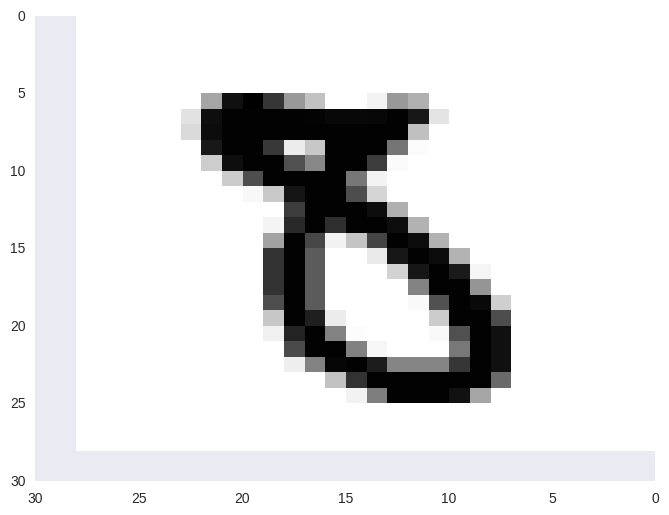

In [15]:
def getImageOfEntry(index_number):
    plt.pcolor(X_subset_test.ix[index_number,:].reshape(28,28))
    ax = plt.gca()
    ax.invert_xaxis()
    ax.invert_yaxis()
    
    print y_subset_test.ix[index_number], ' misclassified as a ', y_subset_test_pred.ix[index_number]
    
getImageOfEntry(2374)

8  misclassified as a  9


0                   0.01
1                   0.05
2                   0.06
3                   0.03
4                   0.10
5                   0.01
6                   0.01
7                   0.23
8                   0.12
9                   0.38
predicted_number    9.00
actual_number       8.00
Name: 5294, dtype: float64

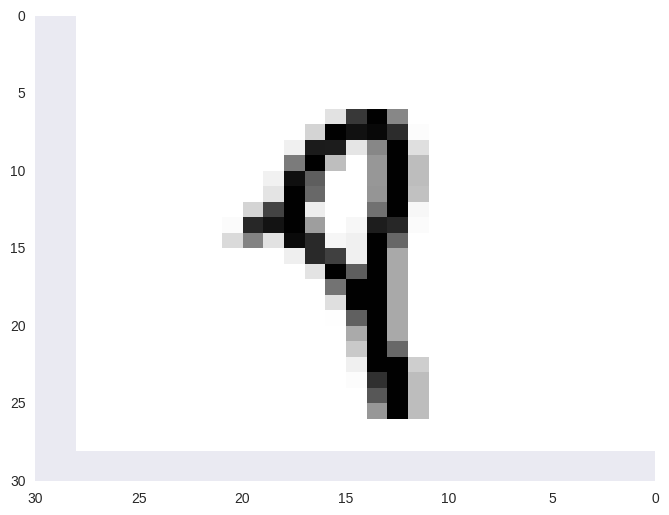

In [16]:
current_index = test_pred_prob_8s_misclassified.index[14]
getImageOfEntry(current_index)
test_pred_prob_8s_misclassified.ix[current_index,:]

## Investigating prediction probabilities

In [21]:
import qgrid

In [31]:
test_pred_prob['max_prediction_prob'] = test_pred_prob.drop(['predicted_number', 'actual_number'], axis=1).apply(lambda x: x.idxmax(), axis=1)

In [32]:
test_pred_prob[(test_pred_prob['predicted_number'] != test_pred_prob['actual_number'])]

,0,1,2,3,4,5,6,7,8,9,predicted_number,actual_number,max_prediction_prob
2135,0.00,0.00,0.00,0.00,0.69,0.00,0.00,0.00,0.02,0.28,4,9,4
8647,0.09,0.03,0.45,0.04,0.01,0.09,0.20,0.01,0.05,0.02,2,6,2
4644,0.16,0.05,0.01,0.01,0.01,0.63,0.01,0.00,0.12,0.01,5,6,5
6290,0.19,0.02,0.07,0.32,0.01,0.03,0.32,0.01,0.02,0.01,0,3,3
9007,0.00,0.03,0.91,0.01,0.00,0.00,0.01,0.04,0.00,0.00,2,7,2
2153,0.03,0.02,0.31,0.02,0.01,0.38,0.16,0.01,0.05,0.01,2,6,5
3712,0.01,0.01,0.29,0.13,0.02,0.02,0.02,0.02,0.43,0.07,2,3,8
1728,0.00,0.03,0.05,0.24,0.02,0.02,0.00,0.05,0.08,0.50,9,8,9
4632,0.01,0.00,0.05,0.46,0.01,0.16,0.02,0.00,0.28,0.01,3,8,3
9155,0.08,0.01,0.02,0.44,0.01,0.35,0.03,0.02,0.03,0.02,3,5,3
